<a href="https://colab.research.google.com/github/CAS-ML-analytics/Orbitrap_clustering/blob/main/Google_colab_notebooks/Autoencoder_Orbitrap_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The purpose of this notebook is to evaluate various approaches to identifying distinct groupings from measurements taken with the LAAP-TOF instrument (Laser Ablation of Aerosol Particles Time-of-Flight Mass Spectrometer). 

The notebook is structured as follows:

1.   Load data into a Pandas dataframe and set the index to date-time format.
2.   Perform deep learning compression of the data.
3.   Cluster the latent space arising from the deep learning comperssion.
4.   Pre-process the original data and then use standard cluster analysis.
5.   Compare the results from [4] and [3].

The data is loaded from



# Load data into a Pandas dataframe and set the index.

In the following code block we load all the required libraries and mount the Gdrive that contains the instrument data we wish to analyse. This is currently set to my own drive but you can change this accordingly. 

In [ ]:
# Load all required modules and then mount the Gdrive that contains the instrument data
!pip install -q -U keras-tuner
import kerastuner as kt
from google.colab import drive
import pandas as pd
import glob
import pdb
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


drive.mount("/content/gdrive")
path='/content/gdrive/My Drive/Shared_York_Man2/'

     |████████████████████████████████| 71kB 5.4MB/s 
Mounted at /content/gdrive


In [ ]:
#Now load the data [xlsx file] into a Pandas dataframe and select just the values for the peaks
#These are not uniquely identified by any one of m/z, retention time, or chemical formula. So for now we just consider the row on the excel spreadsheet as the unique peak identifier
df_beijing_mz = pd.read_excel(path+'Beijing_Amb3.1_MZ.xlsx',engine='openpyxl')
df_beijing_mz.head()

Make a new dataframe that contains only the data from the different peaks

In [ ]:
#Make a dataframe with the different filters, indexed by the different peaks
df_beijing_filters = df_beijing_mz.iloc[:,list(range(18,194))].copy()
#df_beijing_filters.head()
df_beijing_filters['excel_row'] = range(2,1877)
df_beijing_filters.set_index('excel_row',inplace=True)
df_beijing_filters.head()

(74171, 800)

In [ ]:
df_beijing_filters.info()

In [ ]:
df_beijing_filters.describe()

In [ ]:
transformer = RobustScaler()
# We are going to scale the raw data before passing to an autoencoder. To do
# this lets create a seperate copy of the dataframe
scaled_df = pd.DataFrame(transformer.fit_transform(df_beijing_filters), columns=df_beijing_filters.columns,index=df_beijing_filters.index)
#df_beijing_filt_sc = pd.DataFrame(df_beijing_filters, columns=df_beijing_filters.columns)
# Now extract all of the data as a scaled array
ae_input=scaled_df.to_numpy()
np.count_nonzero(np.isnan(ae_input))  #No NaNs which is good
ae_input.shape

# Perform deep learning compression of the data.

In using a traditional clustering approach, we might pre-select a subset of m/z channels to do the clustering on. However this leaves us with 800 dimensions. Cluster analysis can perform better if we reduce the number of dimensions. There are many ways to perform dimenion reduction, but a technique known as autoencoders use the power of neural networks to extract non-linear relationships between 'channels' [nodes] and learn an appropriate latent space through the process of compression and expansion. These processes are known as encoding and decoding respectively. By using the Keras functional API in Tensorflow we can design our own autoencoder to compress and then decompress the original instrument response. We then perform cluster analysis on this latent [compressed] space. Figure xx provides an example schematic of this operation. 

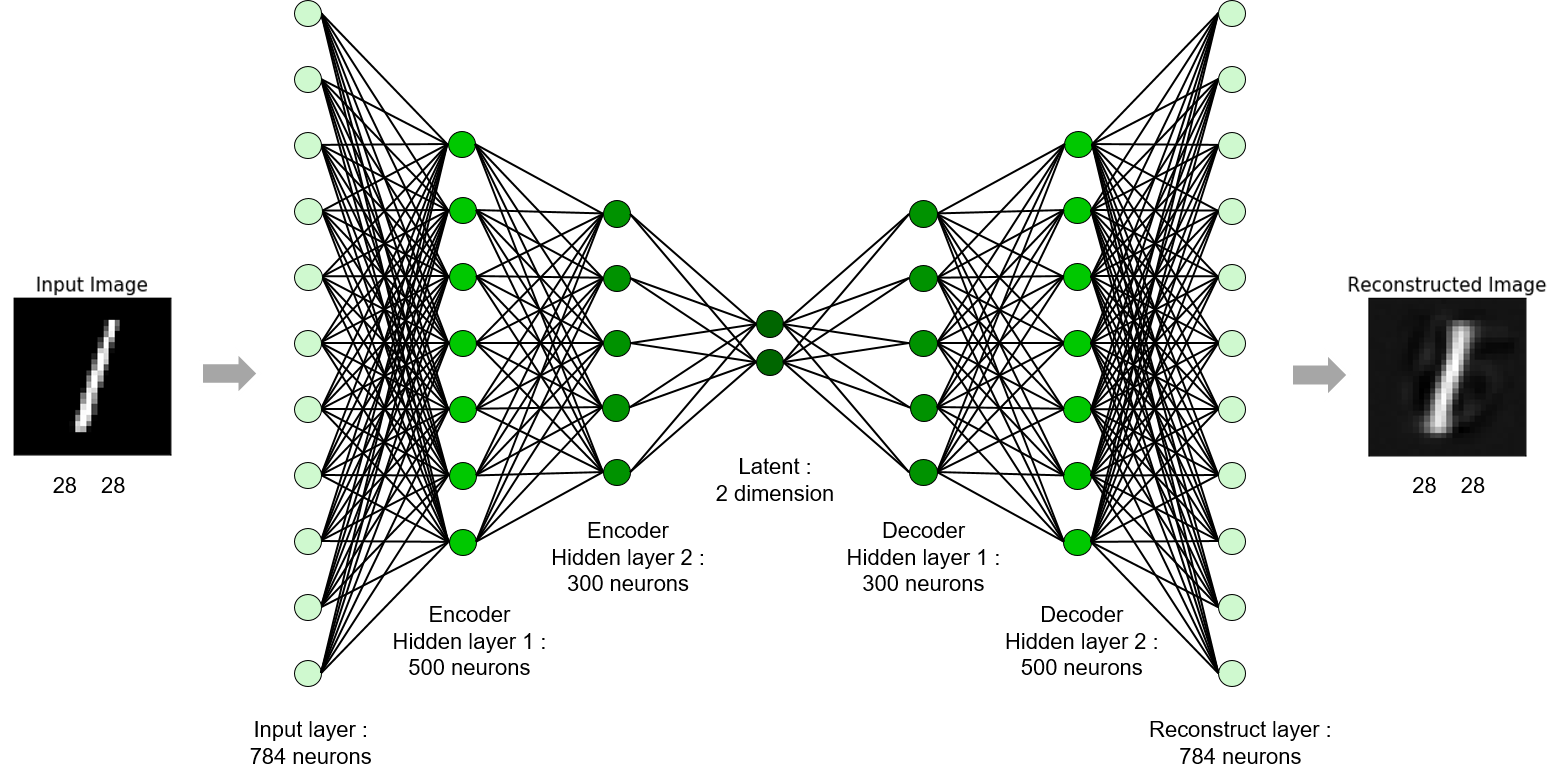

We try a traditional autoencoder and a variational autoencoder. Whilst a traditional AE reconstructs the input through a fixed latent space, a variational autoencoder [VAE] reconstructs the input through a probalistic representation. Essentially this means the latent space becomes a smooth 'surface' and transecting across that surface allows you to generate new outputs [e.g. images]. This is the basis of generative methods, but also in theory provides a more flexible variant for reconstructing ms signals. The devil is in the code detail, which have been taken and modified from either the Tensorflow and/or Keras documentation where appropriate. 



**Stacked autoencoder [with hyperparameer search]**

Create a deep autoencoder, using the linear activation function on the final layer. We go from 800 dimensions to 'latent_dim' dimensions
First we build the encoder part of the model, then the decoder, and combine them both to formulate the final model. This is a modified structure taken from the functional APi version of https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example

In [ ]:
original_dim = len(subset.columns)
#intermediate_dim1_vae = original_dim//2
#intermediate_dim2_vae = original_dim//5
#intermediate_dim3_vae = original_dim//10
#latent_dim_vae = 8

# - uncomment the following if using a Variational autoencoder. 
#class Sampling(layers.Layer):
#    """Uses (z_mean, z_log_var) to sample z."""#
#
#    def call(self, inputs):
#        z_mean, z_log_var = inputs
#        batch = tf.shape(z_mean)[0]
#        dim = tf.shape(z_mean)[1]
#        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def model_builder(hp):

  intermediate_dim1_hp_units = hp.Int('units1', min_value=400, max_value=800, step=20)
  intermediate_dim2_hp_units = hp.Int('units2', min_value=200, max_value=400, step=20)
  intermediate_dim3_hp_units = hp.Int('units3', min_value=100, max_value=200, step=10)
  latent_dim_units = hp.Int('latent_units', min_value=10, max_value=100, step=5)

  original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
  layer1_vae = layers.Dense(intermediate_dim1_hp_units, activation="relu")(original_inputs)
  layer2_vae = layers.Dense(intermediate_dim2_hp_units, activation="relu")(layer1_vae)
  layer3_vae = layers.Dense(intermediate_dim3_hp_units, activation="relu")(layer2_vae)
  layer4_vae = layers.Dense(latent_dim_units, activation="relu")(layer3_vae)
  #z_mean = layers.Dense(latent_dim_units, name="z_mean")(layer3_vae)
  #z_log_var = layers.Dense(latent_dim_units, name="z_log_var")(layer3_vae)
  #z = Sampling()((z_mean, z_log_var))
  encoder_ae = tf.keras.Model(inputs=original_inputs, outputs=layer4_vae, name="encoder_ae")

  # Define decoder model.
  latent_inputs_ae = tf.keras.Input(shape=(latent_dim_units,), name="z_sampling")
  dec_layer1_vae = layers.Dense(intermediate_dim3_hp_units, activation="relu")(latent_inputs_ae)
  dec_layer2_vae = layers.Dense(intermediate_dim2_hp_units, activation="relu")(dec_layer1_vae)
  dec_layer3_vae = layers.Dense(intermediate_dim1_hp_units, activation="relu")(dec_layer2_vae)
  outputs_vae = layers.Dense(original_dim, activation="linear")(dec_layer3_vae)
  decoder_ae = tf.keras.Model(inputs=latent_inputs_ae, outputs=outputs_vae, name="decoder_vae")

  # Define VAE model.
  outputs = decoder_ae(layer4_vae)
  ae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")
  # Add KL divergence regularization loss.
  #kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
  #vae.add_loss(kl_loss)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  ae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

  return ae

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',overwrite=True)

tuner.search(ae_input, ae_input, epochs=50, validation_data=(ae_input, ae_input))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, the second {best_hps.get('units2')}, third {best_hps.get('units3')}, latent {best_hps.get('latent_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 01m 35s]
val_loss: 1.4527688108501025e-05

Best val_loss So Far: 2.4213748019974446e-06
Total elapsed time: 00h 19m 49s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 700, the second 300, third 120, latent 40 and the optimal learning rate for the optimizer
is 0.001.



Now that we have trialed a few combinations, we can extract the best parameters and refit a model to reproduce the entire data. This includes extracting the number of epochs after which training does not improve. We produce a plot that shows how the training proceeds by plotting the loss metrics. 


Epoch 1/30
2318/2318 [==============================] - 10s 4ms/step - loss: 4.4838e-05 - val_loss: 6.1322e-06
Epoch 2/30
2318/2318 [==============================] - 9s 4ms/step - loss: 5.7843e-06 - val_loss: 4.7834e-06
Epoch 3/30
2318/2318 [==============================] - 9s 4ms/step - loss: 4.4245e-06 - val_loss: 3.9185e-06
Epoch 4/30
2318/2318 [==============================] - 9s 4ms/step - loss: 3.7595e-06 - val_loss: 3.3083e-06
Epoch 5/30
2318/2318 [==============================] - 9s 4ms/step - loss: 3.4271e-06 - val_loss: 3.4818e-06
Epoch 6/30
2318/2318 [==============================] - 9s 4ms/step - loss: 3.0774e-06 - val_loss: 2.7232e-06
Epoch 7/30
2318/2318 [==============================] - 9s 4ms/step - loss: 2.8641e-06 - val_loss: 3.1664e-06
Epoch 8/30
2318/2318 [==============================] - 9s 4ms/step - loss: 2.7211e-06 - val_loss: 2.6150e-06
Epoch 9/30
2318/2318 [==============================] - 9s 4ms/step - loss: 2.6069e-06 - val_loss: 2.5647e-06
Epoch 10/

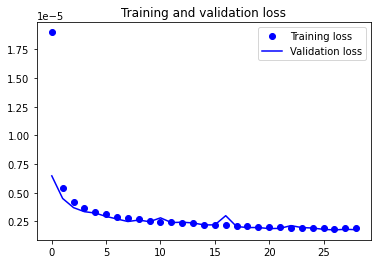

In [ ]:

# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(ae_input, ae_input, epochs=30, validation_data=(ae_input, ae_input))
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history_new = hypermodel.fit(ae_input, ae_input, epochs=best_epoch, validation_data=(ae_input, ae_input))

# plot loss history
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Perform cluster analysis

Now that we have our optimised AE, we can predict the latent space. To do that, we need to rebuild our autoencoder since we cannot access the encoder part of our model.  However, not to worry since we have recorded the best set of parameters. In the following code block we retrain the autoencoder and then we are going to extract the output from only the encoder model and then use this for cluster analysis. 

In [ ]:
# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
layer1_vae = layers.Dense(best_hps.get('units1'), activation="relu")(original_inputs)
layer2_vae = layers.Dense(best_hps.get('units2'), activation="relu")(layer1_vae)
layer3_vae = layers.Dense(best_hps.get('units3'), activation="relu")(layer2_vae)
layer4_vae = layers.Dense(best_hps.get('latent_units'), activation="relu")(layer3_vae)
#z_mean = layers.Dense(best_hps.get('latent_units'), name="z_mean")(layer3_vae)
#z_log_var = layers.Dense(best_hps.get('latent_units'), name="z_log_var")(layer3_vae)
#z = Sampling()((z_mean, z_log_var))
encoder_ae = tf.keras.Model(inputs=original_inputs, outputs=layer4_vae, name="encoder_ae")

# Define decoder model.
latent_inputs_ae = tf.keras.Input(shape=(best_hps.get('latent_units'),), name="decoder_input")
dec_layer1_vae = layers.Dense(best_hps.get('units3'), activation="relu")(latent_inputs_ae)
dec_layer2_vae = layers.Dense(best_hps.get('units2'), activation="relu")(dec_layer1_vae)
dec_layer3_vae = layers.Dense(best_hps.get('units1'), activation="relu")(dec_layer2_vae)
outputs_ae = layers.Dense(original_dim, activation="linear")(dec_layer3_vae)
decoder_ae = tf.keras.Model(inputs=latent_inputs_ae, outputs=outputs_ae, name="decoder_ae")

# Define VAE model.
outputs = decoder_ae(layer4_vae)
ae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="ae")

# Add KL divergence regularization loss.
#kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
#vae.add_loss(kl_loss)

# Model summary
print(ae.summary())
#train_data,test_data,_,_ = train_test_split(vae_input,vae_input,test_size=0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
ae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
training_history = ae.fit(ae_input, ae_input, epochs=best_epoch, validation_data=(ae_input, ae_input))

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 800)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 700)               560700    
_________________________________________________________________
dense_9 (Dense)              (None, 300)               210300    
_________________________________________________________________
dense_10 (Dense)             (None, 120)               36120     
_________________________________________________________________
dense_11 (Dense)             (None, 40)                4840      
_________________________________________________________________
decoder_ae (Functional)      (None, 800)               812720    
Total params: 1,624,680
Trainable params: 1,624,680
Non-trainable params: 0
______________________________________________________

Now we use the trained encoder part of our model to extract the deep learning latent space. We can then perform cluster analysis on this latent space. If we define the number of clusters we then add these cluster labels back into our original dataset [data-frame].  We can then, for example, see what time of the day, certain clusters appear. First, lets call the encoder and extract our new latent space. Following this, we apply cluster analysis to this new space. Just to confirm, each row in in new space is the new latent representation of our traffic network at a given point in time.

In [ ]:
# Call the now re-trained encoder part of our model
latent_space = encoder_ae.predict(ae_input)
latent_space.shape


(74171, 40)

In [ ]:
# Now we can perform agglomerative cluster analysis on this new ouput, assigning each row to a particular cluster. We have to define the number of clusters but thats ok for now
from sklearn.cluster import AgglomerativeClustering 
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'ward')
clustering = agglom.fit(latent_space)

We can now extract the label that 'AgglomerativeClustering' has generated to each observation and add this information back into our original dataframe. We do this by accessing the 'clustering.labels_' property. I then produce individual columns for each cluster label, with a 1 or 0 to state whether that cluster occured. The reason for this is that I may also want to count how many times a cluster appears during the day, to get a daily average. This will then allow us to better visualise when certain conditions occur during the year. You will see I then create a new dataframe called 'daily_summary' so we can produce a daily plot.


In [ ]:
# Create a new dataframe and then apply a scaler before performing cluster analysis

reduced_dimension_frame = pd.DataFrame(latent_space)
reduced_dimension_frame['intensity_n_total']=site_data['intensity_n_total'].values.astype(float)
reduced_dimension_frame['intensity_p_total']=site_data['intensity_p_total'].values.astype(float)
reduced_dimension_frame=reduced_dimension_frame.dropna()
#site_data['intensity_n_total']
transformer = RobustScaler()
scaled_df_new = pd.DataFrame(transformer.fit_transform(reduced_dimension_frame), columns=reduced_dimension_frame.columns)

NameError: ignored

In [ ]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'ward')
clustering = agglom.fit(scaled_df_new)
site_data['label']=clustering.labels_
site_data['label']
site_data['1'] = np.where(site_data['label'] == 0, 1,0)
site_data['2'] = np.where(site_data['label'] == 1, 1,0)
site_data['3'] = np.where(site_data['label'] == 2, 1,0)
site_data['4'] = np.where(site_data['label'] == 3, 1,0)
site_data['5'] = np.where(site_data['label'] == 4, 1,0)
site_data['6'] = np.where(site_data['label'] == 5, 1,0)
minute_summary = pd.DataFrame()
minute_summary['1'] = site_data['1'].resample('30min').sum()
minute_summary['2'] = site_data['2'].resample('30min').sum()
minute_summary['3'] = site_data['3'].resample('30min').sum()
minute_summary['4'] = site_data['4'].resample('30min').sum()
minute_summary['5'] = site_data['5'].resample('30min').sum()
minute_summary['6'] = site_data['6'].resample('30min').sum()

Now we do the same but for the original input [not VAE latent space]

In [ ]:
#now do the same but with the total dataset
reduced_dimension_frame_old = pd.DataFrame(ae_input)
reduced_dimension_frame_old['intensity_n_total']=site_data['intensity_n_total'].values.astype(float)
reduced_dimension_frame_old['intensity_p_total']=site_data['intensity_p_total'].values.astype(float)
reduced_dimension_frame_old=reduced_dimension_frame_old.dropna()
#site_data['intensity_n_total']
transformer_old = RobustScaler()
scaled_df_old = pd.DataFrame(transformer.fit_transform(reduced_dimension_frame_old), columns=reduced_dimension_frame_old.columns)

In [ ]:
agglom_old = AgglomerativeClustering(n_clusters = 6, linkage = 'ward')
clustering_old = agglom.fit(scaled_df_old)
site_data['label_old']=clustering_old.labels_
site_data['label_old']
site_data['1_old'] = np.where(site_data['label_old'] == 0, 1,0)
site_data['2_old'] = np.where(site_data['label_old'] == 1, 1,0)
site_data['3_old'] = np.where(site_data['label_old'] == 2, 1,0)
site_data['4_old'] = np.where(site_data['label_old'] == 3, 1,0)
site_data['5_old'] = np.where(site_data['label_old'] == 4, 1,0)
site_data['6_old'] = np.where(site_data['label_old'] == 5, 1,0)
minute_summary_old = pd.DataFrame()
minute_summary_old['1'] = site_data['1_old'].resample('30min').sum()
minute_summary_old['2'] = site_data['2_old'].resample('30min').sum()
minute_summary_old['3'] = site_data['3_old'].resample('30min').sum()
minute_summary_old['4'] = site_data['4_old'].resample('30min').sum()
minute_summary_old['5'] = site_data['5_old'].resample('30min').sum()
minute_summary_old['6'] = site_data['6_old'].resample('30min').sum()


Now we can compare the profile of clusters occuring over time. 

No handles with labels found to put in legend.


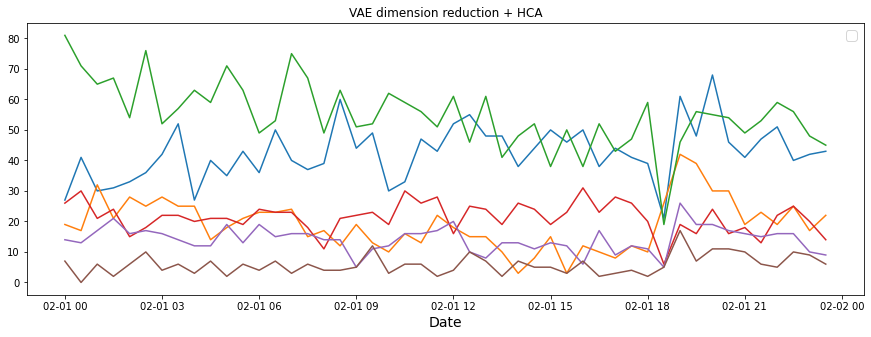

In [ ]:
fig = plt.figure(figsize=(15, 5))
#plt.plot(minute_summary.index,minute_summary['1'], color='r', label='1')
#plt.plot(minute_summary.index,minute_summary['2'], color='g', label='2')
#plt.plot(minute_summary.index,minute_summary['3'], color='b', label='3')
#plt.plot(minute_summary.index,minute_summary['4'], color='k', label='4')
plt.plot(minute_summary)

ax = fig.gca()
ax.set_xlabel("Date", size=14)
plt.title('VAE dimension reduction + HCA')
plt.legend(prop={"size":14});


No handles with labels found to put in legend.


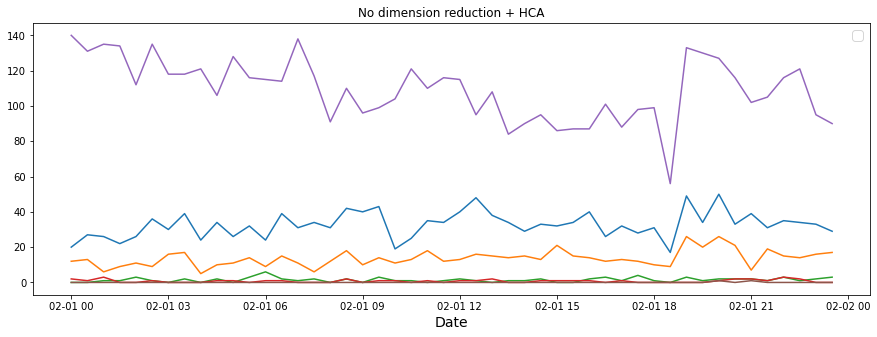

In [ ]:
fig = plt.figure(figsize=(15, 5))
#plt.plot(minute_summary.index,minute_summary['1'], color='r', label='1')
#plt.plot(minute_summary.index,minute_summary['2'], color='g', label='2')
#plt.plot(minute_summary.index,minute_summary['3'], color='b', label='3')
#plt.plot(minute_summary.index,minute_summary['4'], color='k', label='4')
plt.plot(minute_summary_old)

ax = fig.gca()
ax.set_xlabel("Date", size=14)
plt.title('No dimension reduction + HCA')
plt.legend(prop={"size":14});
